In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats

In [2]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

In [3]:
ds_base = xr.open_mfdataset('cmip6_data/tas_Amon_GFDL-ESM4_esm-piControl_r1i1p1f1_gr1*')

In [4]:
ds_1pct = xr.open_mfdataset('cmip6_data/tas_Amon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1*')

In [5]:
ds_1pct = utils._regrid_ds(ds_1pct, ds_out)
ds_base = utils._regrid_ds(ds_base, ds_out)

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [6]:
ds_dif = ds_1pct - ds_base

In [7]:
anom_dif = (ds_dif.groupby("time.month") - ds_dif.groupby("time.month").mean(dim = 'time'))
anom_dif = anom_dif.groupby('time.year').mean()

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 75 times more chunks
  return self.array[key]


In [8]:
ds_dif = ds_dif.groupby('time.year').mean()

anom_base = (ds_base.groupby("time.month") - ds_base.groupby("time.month").mean(dim = 'time'))
anom_1pct = (ds_1pct.groupby("time.month") - ds_1pct.groupby("time.month").mean(dim = 'time'))
anom_dif = anom_1pct - anom_base
anom_dif = anom_dif.groupby('time.year').mean()

In [9]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['tas']
G_mean_ds = xr.open_dataset('Outputs/G_mean_ds.nc4')['tas']

anom_G_ds = xr.open_dataset('Outputs/anom_G_ds.nc4')['tas']
anom_G_mean_ds = xr.open_dataset('Outputs/anom_G_mean_ds.nc4')['tas']

In [10]:
A = utils.find_area(ds_out)

## Linear Regression

In [11]:
G_ds_weighted_mean = G_mean_ds.weighted(A).mean(dim = ['lat','lon']).dropna(dim = 'year')

In [12]:
ds_dif_weighted_mean = ds_dif.weighted(A).mean(dim = ['lat','lon']).dropna(dim = 'year')['tas']

In [13]:
def linregress_ds(ds_in, time_var):
    '''Linear regression along a dataarray/dataset variable, returning a new dataset of the same shape. Must select a variable from the dataset or use a data array
    time_var is the name of the time variable (eg: year, time, etc)'''
    ds_linregress = xr.zeros_like(ds_in)
    ds_linregress[time_var] = np.arange(0,len(ds_in[time_var]))
    ds_linregress = ds_linregress.rename({time_var:'time'})
    ds_linregress.time.attrs = {'unit':time_var}
    for t in np.arange(1, len(ds_in[time_var])):
        x = np.arange(0,len(ds_in[time_var]))[:t]
        y = ds_in.values[:t]
        res = stats.linregress(x,y)
        time_var = time_var
        ds_linregress.loc[dict(time = t)] = res.slope
    return(ds_linregress)

In [29]:
ds_dif_regress = linregress_ds(ds_dif_weighted_mean, 'year')

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [30]:
ds_dif_regress.to_netcdf('ds_dif_regress.nc4')

G_linregress = linregress_ds(G_ds_weighted_mean, 'year')

plt.plot(G_linregress)
plt.plot(G_ds_weighted_mean)

## Rolling means

In [14]:
G_10yr_roll_ds = G_ds.rolling(year = 10).mean(center = True).dropna("year")
G_20yr_roll_ds = G_ds.rolling(year = 20).mean(center = True).dropna("year")

In [15]:
G_10yr_mean_roll_ds = G_mean_ds.rolling(year = 10).mean(center = True).dropna("year")
G_20yr_mean_roll_ds = G_mean_ds.rolling(year = 20).mean(center = True).dropna("year")

In [16]:
G_ds = G_ds.rename({'year':'s'})
G_10yr_roll_ds = G_10yr_roll_ds.rename({'year':'s'})
G_20yr_roll_ds = G_20yr_roll_ds.rename({'year':'s'})
ds_dif = ds_dif.rename({'year':'s'})


In [25]:
G_mean_ds = G_mean_ds.rename({'year':'s'})
G_10yr_mean_roll_ds = G_10yr_mean_roll_ds.rename({'year':'s'})
G_20yr_mean_roll_ds = G_20yr_mean_roll_ds.rename({'year':'s'})


## GFDL Only Test

GFDL_mod= G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = 'GFDL')
anom_GFDL_mod= anom_G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = 'GFDL')
GFDL_10yr_roll_mod = G_10yr_roll_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = 'GFDL')
GFDL_20yr_roll_mod = G_20yr_roll_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = 'GFDL')

## Global Mean Analysis

In [17]:
emis_profile = {}
emis_profile['annual'] = xr.open_dataset(f'1pct_emis_profile.nc4')
#emis_profile['annual']['Model_mean'] = emis_profile['annual'].mean()
emis_profile['annual'] = emis_profile['annual'].rename({'__xarray_dataarray_variable__':'emis'})

emis_profile['10rolling'] = xr.open_dataset(f'1pct_emis_profile_rolling10.nc4')
#emis_profile['10rolling']['Model_mean'] = emis_profile['10rolling'].groupby('model').mean()
emis_profile['10rolling'] = emis_profile['10rolling'].rename({'__xarray_dataarray_variable__':'emis'})

emis_profile['20rolling'] = xr.open_dataset(f'1pct_emis_profile_rolling20.nc4')
#emis_profile['20rolling']['Model_mean'] = emis_profile['20rolling'].groupby('model').mean()
emis_profile['20rolling'] = emis_profile['20rolling'].rename({'__xarray_dataarray_variable__':'emis'})

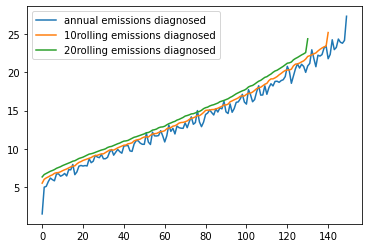

In [18]:
fig, ax = plt.subplots()
for nm in emis_profile.keys():
    plt.plot(emis_profile[nm].mean(dim = 'model')['emis'], label = f'{nm} emissions diagnosed')
plt.legend()
plt.savefig('figures/1pct_increase/emis_profiles.png', bbox_inches = 'tight', dpi = 350)

In [ ]:
GFDL_mod.plot(label = 'Annual Data')
GFDL_10yr_roll_mod.plot(label = 'Rolling 10 year mean')
GFDL_20yr_roll_mod.plot(label = 'Rolling 20 year mean')
anom_GFDL_mod.plot(label = 'Anomaly')
plt.legend()
plt.title('Greens function of temp response to CO2 emissions [degrees/GtC]');
plt.savefig('figures/1pct_increase/single_model_GFDL_GF.png', bbox_inches = 'tight', dpi = 350)
#units of degrees/GtC

In [26]:
%%time
ds_GF_dict = {'annual':G_mean_ds.weighted(A).mean(dim = ['lat','lon']), 
              '10rolling':G_10yr_mean_roll_ds.weighted(A).mean(dim = ['lat','lon']), 
              '20rolling':G_20yr_mean_roll_ds.weighted(A).mean(dim = ['lat','lon'])}
conv_1pct_mean = {}
linregress_1pct_conv = {}

for nm in ds_GF_dict.keys():   
    conv_1pct_mean[nm] = signal.convolve(np.array(emis_profile[nm].mean(dim = 'model')['emis']), np.array(ds_GF_dict[nm]), 'full')
    conv_1pct_mean[nm] = utils.np_to_xr_mean(conv_1pct_mean[nm], ds_GF_dict[nm], emis_profile[nm])
    linregress_1pct_conv[nm] = linregress_ds(conv_1pct_mean[nm], 's') 

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TIN

CPU times: user 859 ms, sys: 78 ms, total: 937 ms
Wall time: 940 ms


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


(0.01, 0.04)

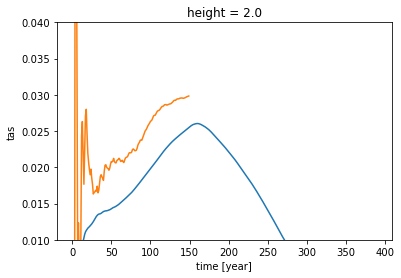

In [31]:
linregress_1pct_conv['annual'].plot()
ds_dif_regress.plot()
plt.ylim(0.01,0.04)
#plt.xlim(60,105)

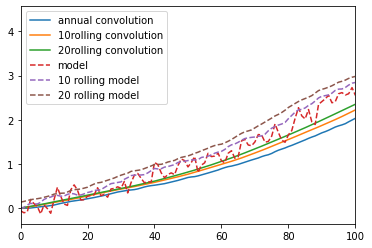

In [28]:
for nm in ['annual', '10rolling', '20rolling']:
    plt.plot(conv_1pct_mean[nm], label = f'{nm} convolution')
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon'])['tas'], label = 'model', linestyle = '--')
plt.plot(np.arange(0,len(ds_dif.weighted(A).mean(dim = ['lat','lon'])['tas'].rolling(s = 10).mean(center = True).dropna("s")['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon'])['tas'].rolling(s = 10).mean(center = True).dropna("s"), label = '10 rolling model', linestyle = '--')
plt.plot(np.arange(0,len(ds_dif.weighted(A).mean(dim = ['lat','lon'])['tas'].rolling(s = 20).mean(center = True).dropna("s")['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon'])['tas'].rolling(s = 20).mean(center = True).dropna("s"), label = '20 rolling model', linestyle = '--')

plt.legend()
plt.xlim(0,100)
plt.savefig('figures/1pct_increase/single_model_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


## Linear Regression specific location analysis

In [265]:
loc_dif = {}
loc_1pct = {}

loc_dif_regress = {}
loc_1pct_conv = {}

loc_lat = {'Antarctic':-80,'North America': 40, 'Africa': 20}
loc_lon = {'Antarctic':200, 'North America': 280, 'Africa': 20}


for loc in loc_lat.keys():
    #select location
    loc_dif[loc] = ds_dif.sel(lat = loc_lat[loc], lon = loc_lon[loc], method = 'nearest')['tas']
    loc_1pct[loc] = conv_1pct['annual'].sel(lat = loc_lat[loc], lon = loc_lon[loc], method = 'nearest')
    #regression
    loc_dif_regress[loc] = xr.zeros_like(loc_dif[loc])
    for t in np.arange(1,len(loc_dif[loc].s)):
        reg = loc_dif[loc].sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)
        loc_dif_regress[loc].loc[dict(s = t)] = reg['polyfit_coefficients'].sel(degree = 1)
    loc_1pct_conv[loc] = xr.zeros_like(loc_1pct[loc])
    for t in np.arange(1,len(loc_1pct[loc].s)):
        reg = loc_1pct[loc].sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)
        loc_1pct_conv[loc].loc[dict(s = t)] = reg['polyfit_coefficients'].sel(degree = 1)

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


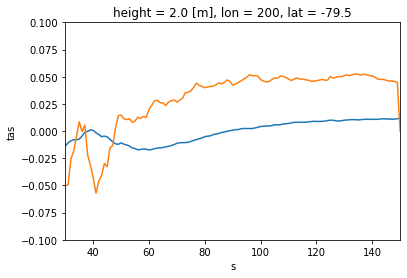

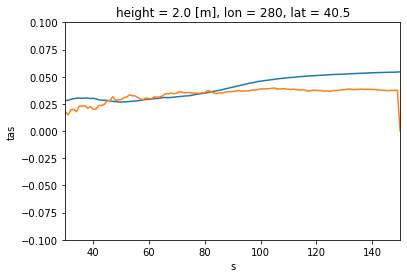

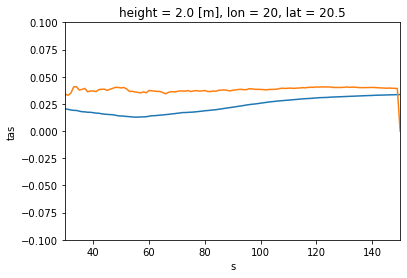

In [275]:
for loc in loc_lat.keys():
    fig, ax = plt.subplots()
    loc_1pct_conv[loc].plot()
    loc_dif_regress[loc].plot()
    plt.ylim(-0.1,0.1)
    plt.xlim(30,150)

## Linear Regression spatial test

In [173]:
linregress_dif = ds_dif.polyfit(dim = 's', deg = 1)

In [224]:
t = 100

In [225]:
test_dif = ds_dif.sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)

In [226]:
test_1pct = conv_1pct['annual'].sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)

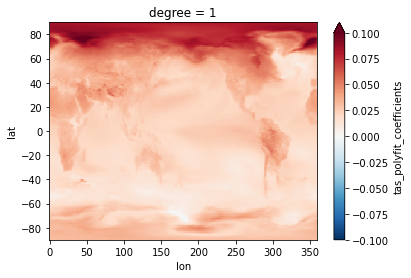

In [282]:
test_dif.sel(degree = 1)['tas_polyfit_coefficients'].plot(vmin = -0.1, vmax = 0.1, cmap = 'RdBu_r')

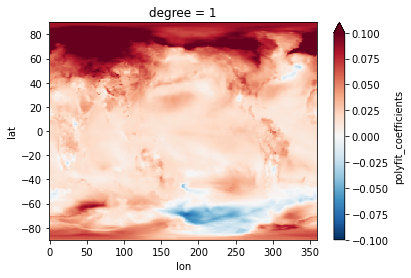

In [283]:
test_1pct.sel(degree = 1)['polyfit_coefficients'].plot(vmin = -0.1, vmax = 0.1, cmap = 'RdBu_r')

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


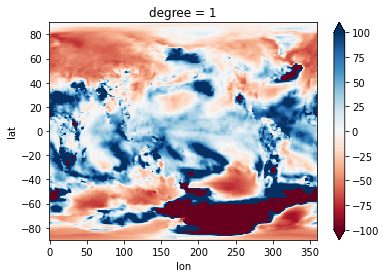

In [236]:
(((test_dif.sel(degree = 1)['tas_polyfit_coefficients']-test_1pct.sel(degree = 1)['polyfit_coefficients'])/
  test_1pct.sel(degree = 1)['polyfit_coefficients'])*100).plot(vmax = 100, vmin = -100, cmap = 'RdBu')

In [234]:
(((test_dif.sel(degree = 1)['tas_polyfit_coefficients']-test_1pct.sel(degree = 1)['polyfit_coefficients'])/test_1pct.sel(degree = 1)['polyfit_coefficients'])*100).mean().values

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


array(-6.1056034)

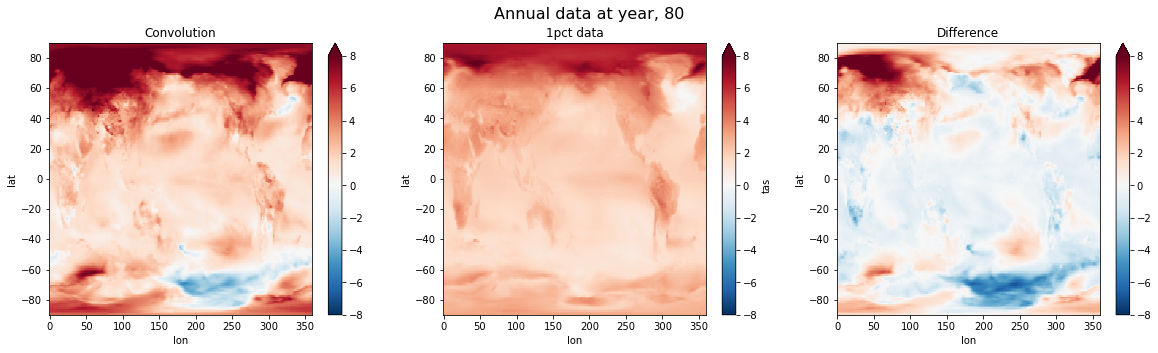

In [228]:
for t in [80]:#, 30, 60, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['annual'].sel(s = slice(t, t+20)).mean('s').plot(ax = ax1, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].sel(s = slice(t, t+20)).mean('s').plot(ax = ax2, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['annual'] - ds_dif['tas']).sel(s = slice(t, t+20)).mean('s').plot(ax = ax3, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(f'Annual data at year, {t}', fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


In [214]:
linregress_1pct = xr.zeros_like(conv_1pct['annual'])
for t in np.arange(1,len(conv_1pct['annual'].s))[80:]:
    reg = conv_1pct['annual'].sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)
    linregress_1pct.loc[dict(s = t)] = reg['tas_polyfit_coefficients'].sel(degree = 1)

KeyboardInterrupt: 

In [ ]:
linregress_dif = xr.zeros_like(ds_dif)
for t in np.arange(1,len(ds_dif.s))[80:]:
    reg = ds_dif.sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)
    linregress_dif.loc[dict(s = t)] = reg['tas_polyfit_coefficients'].sel(degree = 1)

In [ ]:
linregress_dif['tas'].weighted(A).mean(dim = ['lat','lon'])

## Spatial Analysis

In [211]:

ds_GF_dict = {'annual':G_ds,'10rolling':G_10yr_roll_ds, '20rolling':G_20yr_roll_ds}


In [212]:
%%time
conv_1pct = {}
for nm in ds_GF_dict.keys():   
    conv_1pct[nm] = signal.convolve(emis_profile[nm][..., None, None], np.array(ds_GF_dict[nm].sel(model = 'GFDL').fillna(0)), 'full')
    conv_1pct[nm] = utils.np_to_xr(conv_1pct[nm], ds_GF_dict[nm].sel(model = 'GFDL'), emis_profile[nm])

CPU times: user 1.16 s, sys: 604 ms, total: 1.76 s
Wall time: 1.77 s


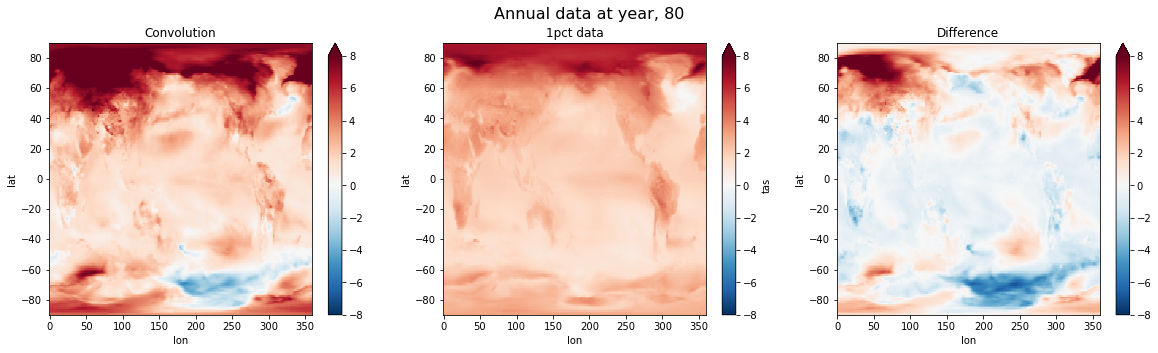

In [32]:
for t in [80]:#, 30, 60, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['annual'].sel(s = slice(t, t+20)).mean('s').plot(ax = ax1, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].sel(s = slice(t, t+20)).mean('s').plot(ax = ax2, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['annual'] - ds_dif['tas']).sel(s = slice(t, t+20)).mean('s').plot(ax = ax3, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(f'Annual data at year, {t}', fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


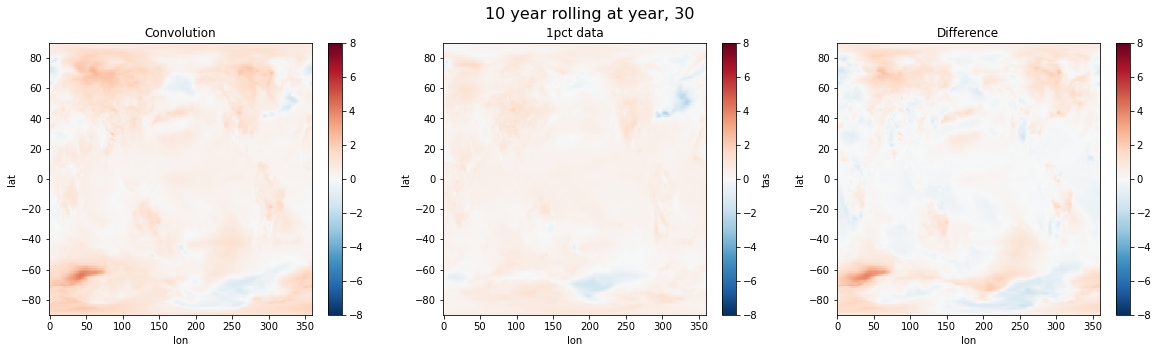

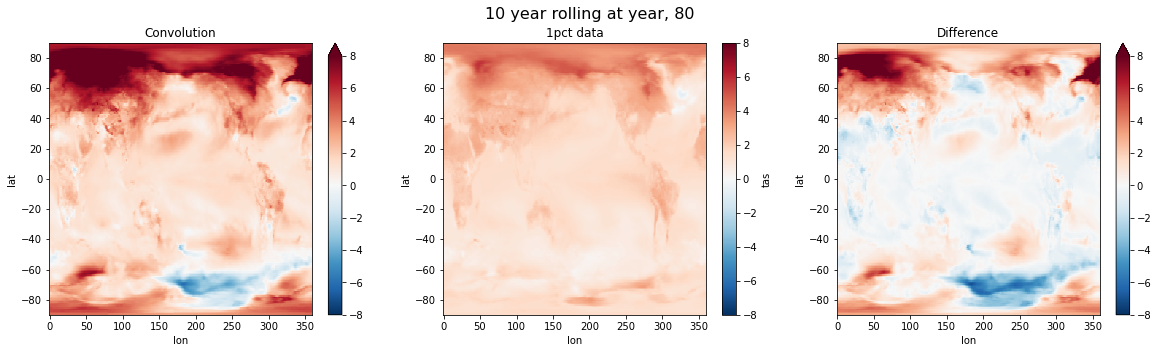

In [30]:
for t in [30, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['10rolling'].sel(s = t).plot(ax = ax1, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].rolling(s = 10).mean('s').dropna('s').sel(s = t).plot(ax = ax2, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['10rolling'].sel(s=t) - ds_dif['tas'].rolling(s = 10).mean('s').dropna('s')).sel(s = t).plot(ax = ax3, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(f'10 year rolling at year, {t}', fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


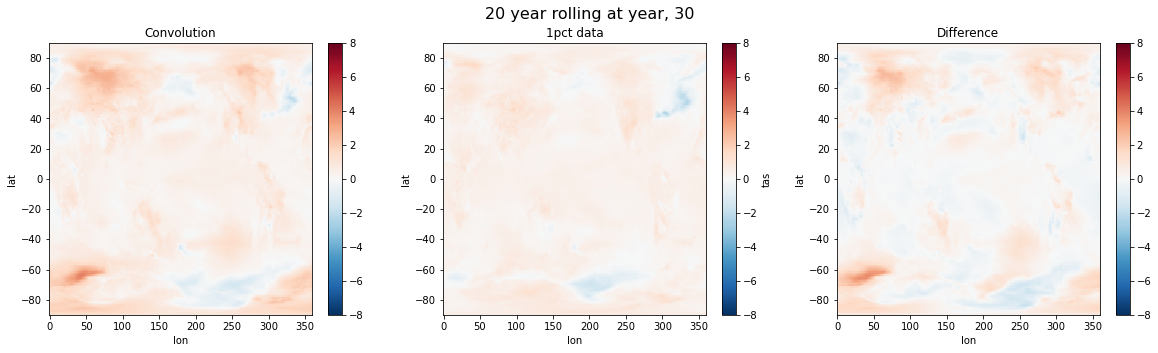

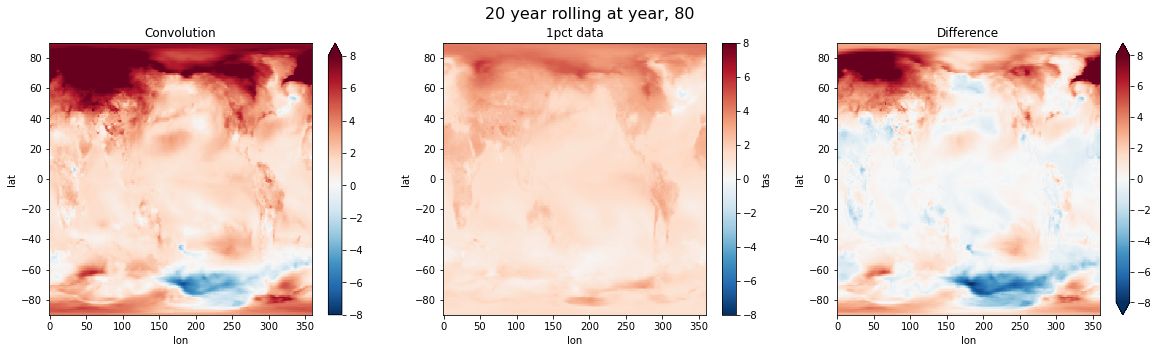

In [31]:
for t in [30, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['20rolling'].sel(s = t).plot(ax = ax1, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].rolling(s = 10).mean('s').dropna('s').sel(s = t).plot(ax = ax2, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['20rolling'].sel(s=t) - ds_dif['tas'].rolling(s = 10).mean('s').dropna('s')).sel(s = t).plot(ax = ax3, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(f'20 year rolling at year, {t}', fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


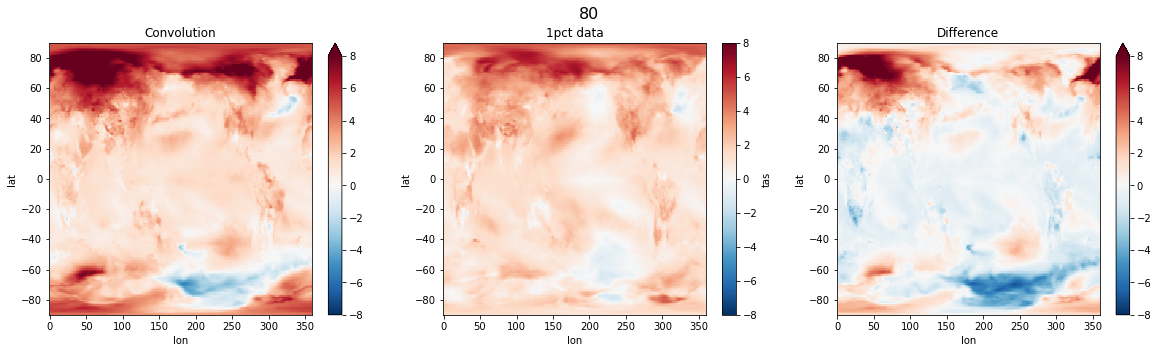

In [23]:
for t in [80]:#, 30, 60, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['sinks'].sel(s = t).plot(ax = ax1, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].sel(s = t).plot(ax = ax2, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['sinks'] - ds_dif['tas']).sel(s = slice(t, t+20)).mean('s').plot(ax = ax3, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(t, fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


## Group base by month 

## Test the start date of our difference

In [24]:
ds_base2 = ds_base.isel(time = slice(12*100,6000))
ds_base2['time'] = ds_base['time'][:len(ds_base2.time)]

In [25]:
ds_base3 = ds_base.isel(time = slice(12*200,6000))
ds_base3['time'] = ds_base['time'][:len(ds_base3.time)]

In [26]:
ds_dif2 = ds_1pct - ds_base2
ds_dif3 = ds_1pct - ds_base3

In [27]:
ds_dif2 = ds_dif2.groupby('time.year').mean()
ds_dif3 = ds_dif3.groupby('time.year').mean()

In [31]:
ds_dif2 = ds_dif2.rename({'year':'s'})
ds_dif3 = ds_dif3.rename({'year':'s'})

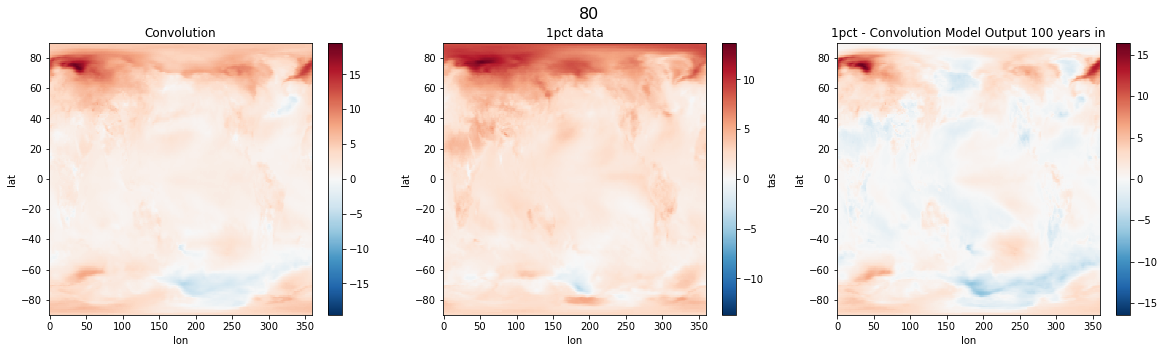

In [32]:
for t in [80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    conv_1pct['sinks'].sel(s = t).plot(ax = ax1)
    ax1.set_title('Convolution')
    
    ds_dif2['tas'].sel(s = t).plot(ax = ax2)
    ax2.set_title('1pct data')
    
    (conv_1pct['sinks'] - ds_dif['tas']).sel(s = t).plot(ax = ax3)
    ax3.set_title('1pct - Convolution Model Output 100 years in')
    
    plt.suptitle(f'{t}', fontsize = 16)

In [ ]:
for t in [80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    conv_1pct['sinks'].sel(s = t).plot(ax = ax1)
    ax1.set_title('Convolution')
    
    ds_dif2['tas'].sel(s = t).plot(ax = ax2)
    ax2.set_title('1pct data')
    
    (conv_1pct['sinks'] - ds_dif['tas']).sel(s = t).plot(ax = ax3)
    ax3.set_title('1pct - Convolution Model Output 100 years in')
    
    plt.suptitle(f'{t}', fontsize = 16)

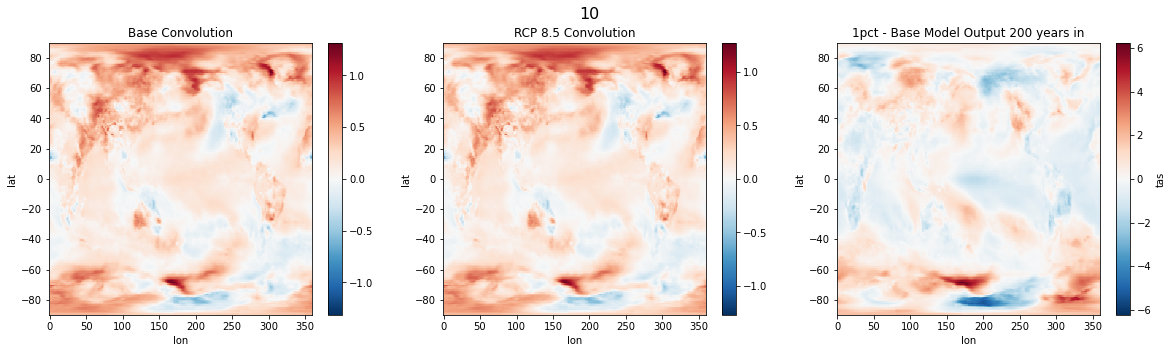

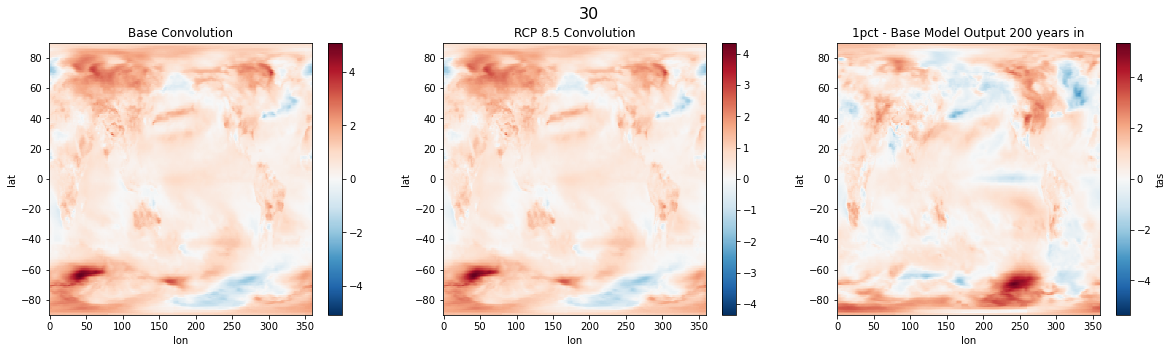

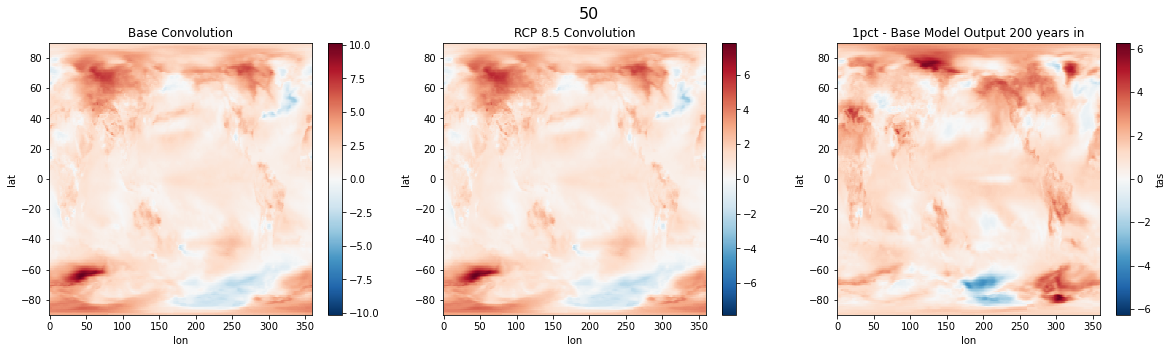

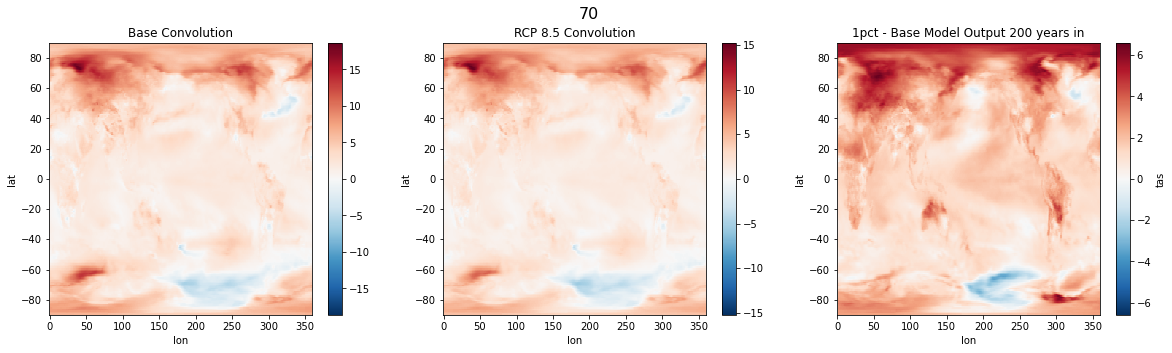

In [123]:
for t in [10,30,50,70]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    conv_1pct['base'].sel(s = t).plot(ax = ax1)
    ax1.set_title('Base Convolution')
    
    conv_1pct['rcp85'].sel(s = t).plot(ax = ax2)
    ax2.set_title('RCP 8.5 Convolution')
    
    ds_dif3['tas'].sel(year = t).plot(ax = ax3)
    ax3.set_title('1pct - Base Model Output 200 years in')
    
    plt.suptitle(f'{t}', fontsize = 16)